In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
offers = pd.read_csv('offerings.csv')

In [3]:
promotionMapper =  {
    'noOffer':0,
    'bronze':1,
    'silver':2,
    'gold':3
}
offers['promotion_type'] = offers['promotion_type'].map(promotionMapper)

In [4]:
educationMapper = {
    'no_hs_diploma':0,
    'grad_high_school':1,
    'some_college':2,
    'grad_college':3,
    'masters_professional':4,
    'phd':5
}
offers['education_level'] = offers['education_level'].map(educationMapper)

In [5]:
target_cols = ['promotion_type','conversion_ind','ltv']
targetFrame = offers[target_cols].copy()
offers = offers.drop(target_cols,axis=1)
num_cols = offers.select_dtypes(np.number).columns
cat_cols = ['residence_type','job_type','primary_credit_card','cable_provider']


# EDA

In [85]:
targetFrame.conversion_ind.value_counts()

1.0    5040
0.0    4961
Name: conversion_ind, dtype: int64

In [86]:
targetFrame.promotion_type.value_counts()

1    3457
2    3328
3    3216
Name: promotion_type, dtype: int64

<AxesSubplot: xlabel='ltv', ylabel='Density'>

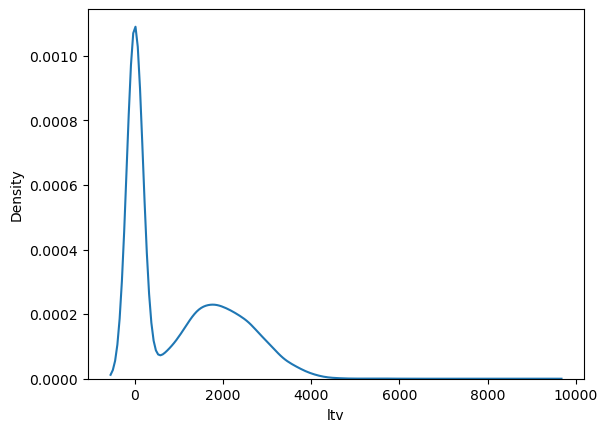

In [87]:
sns.kdeplot(targetFrame.ltv)

## data preprocess

In [6]:
from sklearn.preprocessing import OneHotEncoder

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

In [8]:
ohe.fit(offers[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [9]:
simpleX = offers[num_cols].join(
    pd.DataFrame(ohe.transform(offers[cat_cols]),columns=ohe.get_feature_names_out())
)

# data split

In [14]:
from sklearn.model_selection import train_test_split

In [ ]:
RANDOM_SEED = 1337

In [18]:
xTrain, xTest, yTrain, yTest = train_test_split(simpleX,targetFrame,test_size=0.2)

# conversion model

In [116]:
from xgboost import XGBClassifier,XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

## Logistic

In [65]:
logReg = LogisticRegression(penalty='l2',class_weight='balanced',max_iter=1000)

In [66]:
logReg.fit(
    xTrain.join(yTrain['promotion_type']).fillna(0),
    yTrain['conversion_ind'])

c:\Users\j3ff1\anaconda3\envs\telecomChurn\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [69]:
logTrainPreds = logReg.predict_proba(xTrain.join(yTrain['promotion_type']).fillna(0))

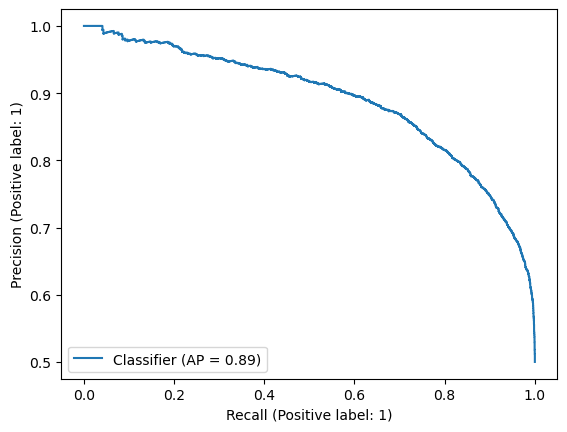

In [70]:
PrecisionRecallDisplay.from_predictions(yTrain['conversion_ind'],logTrainPreds[:,1])

## XGB

In [106]:
prop = yTrain.conversion_ind.value_counts()
scale_weight = prop.loc[0]/prop.loc[1]

In [109]:
xgbClf = XGBClassifier(
    gamma=0,
    objective= 'binary:logistic',
    importance_type='gain',
    nthread=4,
    seed=RANDOM_SEED,
    scale_pos_weight=scale_weight
)

In [208]:
xgb_grid_cv = GridSearchCV(
    xgbClf,
    param_grid={
        'learning_rate':[0.3],
        'n_estimators':[10],
        'min_child_weight':[1,2],
        'max_depth':[5,6],
        'colsample_bytree':[0.9,1],
        'colsample_bylevel':[0.9],
        'subsample':[1]
    },
    scoring='average_precision',cv=5)
xgb_grid_cv.fit(xTrain.join(yTrain['promotion_type']),yTrain['conversion_ind'])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None, ...),
             param_grid={'colsample_bylevel': [0.9],
                         'colsample_bytree': [0.9, 1], 'learning_rate': [0.3],
                         'max_depth': [5, 6], 'min_child_weight': [1, 2],
                         'n_estimators': [10], 'subsample': [1]},
             scoring='average_precision')

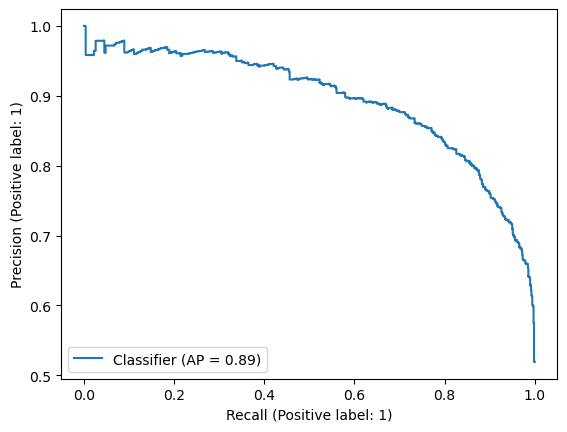

In [213]:
PrecisionRecallDisplay.from_predictions(
    yTest['conversion_ind'],
    xgb_grid_cv.predict_proba(xTest.join(yTest['promotion_type']))[:,1]
)

In [58]:
convImps = pd.Series(
    xgb_grid_cv.best_estimator_.feature_importances_,
        index=xTrain.join(yTrain['promotion_type']).columns
).sort_values(ascending=False)

# ltv model

In [117]:
xgbReg = XGBRegressor(
    gamma=0,
    objective='reg:squarederror',
    nthread=4,
    seed=RANDOM_SEED
)

In [167]:
reg_xgb_grid_cv = GridSearchCV(
    xgbReg,
    param_grid={
        'learning_rate':[0.2],
        'n_estimators':[10,15],
        'min_child_weight':[1,2],
        'max_depth':[5,6,7],
        'colsample_bytree':[0.9,1],
        'colsample_bylevel':[0.9,1]
    },
    scoring='neg_mean_squared_error',cv=5)

In [168]:
inX = xTrain.join(yTrain[['conversion_ind','promotion_type']])
inY = np.log(yTrain['ltv']+0.0001)
reg_xgb_grid_cv.fit(inX,inY)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, nthread=4,
                                    num_parallel_tree=None, predictor=None, ...),
             param_grid={'colsample_bylevel': [0.9, 1],
                         'colsample_bytree': [0.9, 1], 'learning_rate': [0.2],
                         'max_depth': [5, 6, 7], 'min_child_weight': [1, 2],
                         'n_estimators': [10, 15]},
             scoring='neg_mean_squared_error')

In [171]:
pd.Series(
    reg_xgb_grid_cv.best_estimator_.feature_importances_,
        index=inX.columns
).sort_values(ascending=False)

conversion_ind                   0.993358
cable_provider_Spectral          0.001106
age                              0.000658
prior_year_spend                 0.000641
last_ticket_purchase_year        0.000610
job_type_legal                   0.000549
job_type_retail                  0.000548
prior_year_spend_external        0.000503
other_streaming_services         0.000448
num_tickets_purchased            0.000381
cable_provider_DefecTV           0.000374
number_years_at_job              0.000229
cable_provider_Suboptimal        0.000192
job_type_service                 0.000165
education_level                  0.000163
promotion_type                   0.000040
job_type_finance                 0.000032
job_type_business                0.000002
cable_provider_Sub-optimal       0.000001
cable_provider_Infinity          0.000000
primary_credit_card_nan          0.000000
cable_provider_Cheezeline        0.000000
residence_type_S                 0.000000
cable_provider_Fish Network      0

<AxesSubplot: xlabel='ltv'>

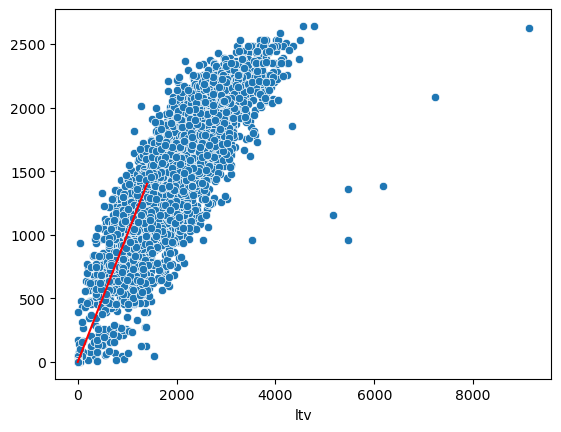

In [172]:
ax = sns.scatterplot(x=yTrain.ltv,y=np.e**reg_xgb_grid_cv.best_estimator_.predict(inX))
sns.lineplot(x=[0,1400],y=[0,1400],color='red',ax=ax)

<AxesSubplot: xlabel='ltv'>

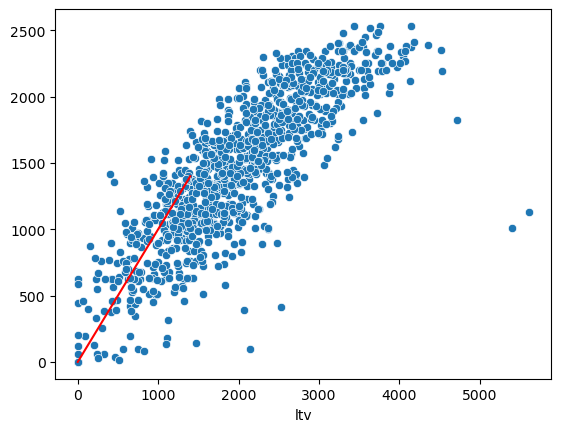

In [214]:
ax = sns.scatterplot(
    x=yTest.ltv,
    y=np.e**reg_xgb_grid_cv.best_estimator_.predict(
        xTest.join(yTest[['conversion_ind','promotion_type']])
    )
)
sns.lineplot(x=[0,1400],y=[0,1400],color='red',ax=ax)

# testing

In [203]:
bronze = pd.Series(np.ones(xTest.shape[0]),index=xTest.index).rename('promotion_type')
silver = bronze*2
gold = bronze*3

In [204]:
inX = pd.concat([xTest.join(bronze),xTest.join(silver),xTest.join(gold)])

In [207]:
xgb_grid_cv.best_estimator_.predict(inX)

array([0, 0, 0, ..., 0, 1, 0])